In [28]:
import numpy as np
import scipy.linalg as la
from qiskit import quantum_info as qi
from qiskit import QuantumCircuit

In [12]:
def b_mat(i, j, n):
    basis_matrix = np.zeros((n, n), dtype=np.float32)
    basis_matrix[i, j] = 1.0

    return basis_matrix

def generate_gell_mann(order):
    lst_of_gm_matrices = []
    for k in range(order):
        j = 0
        while j < k:
            sym_mat = b_mat(j, k, order) + b_mat(k, j, order)
            anti_sym_mat = complex(0.0, -1.0) * (b_mat(j, k, order) - b_mat(k, j, order))

            lst_of_gm_matrices.append(sym_mat), lst_of_gm_matrices.append(anti_sym_mat)
            j += 1

        if k < (order - 1):
            n = k + 1
            coeff = np.sqrt(2 / (n*(n+1)))

            sum_diag = b_mat(0, 0, order)
            for i in range(1, k+1):
                sum_diag += b_mat(i, i, order)
            
            diag_mat = coeff * (sum_diag - n*(b_mat(k+1, k+1, order)))
            lst_of_gm_matrices.append(diag_mat)

    return lst_of_gm_matrices

In [24]:
i_hat = np.array([[1.0, 0.0],
                  [0.0, 0.0]])
j_hat = np.array([[0.0, 0.0],
                 [0.0, 1.0]])
X = np.array([[0.0, 1.0],
              [1.0, 0.0]])
identity = i_hat + j_hat

a = np.kron(i_hat, identity) 
b = np.kron(j_hat, X)

print(a)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [25]:
num_control_qubits = 4

divisors = range(num_control_qubits-1, -1, -1)
divisors = [2**i for i in divisors]
print(divisors)

params = [1.0, 1,2, 1.3, 1.4]
circ = QuantumCircuit(4, 4)
for iterarion_num, theta in zip(range(1, 2**num_control_qubits + 1), params):
    circ.rz(theta, 3)


[8, 4, 2, 1]


In [51]:
import numpy as np
import scipy.linalg as la
from qiskit import quantum_info as qi
from qiskit import QuantumCircuit
import pprint


# Helper Functions ################################################
def b_mat(i, j, n):
    basis_matrix = np.zeros((n, n), dtype=np.float32)
    basis_matrix[i, j] = 1.0

    return basis_matrix


def generate_gell_mann(order):

    lst_of_gm_matricies = []
    for k in range(order):
        j = 0
        while j < k:
            sym_mat = b_mat(j, k, order) + b_mat(k, j, order)
            anti_sym_mat = complex(0.0, -1.0) * (b_mat(j, k, order) - b_mat(k, j, order))

            lst_of_gm_matricies.append(sym_mat), lst_of_gm_matricies.append(anti_sym_mat)
            j += 1

        if k < (order - 1):
            n = k + 1
            coeff = np.sqrt(2 / (n*(n+1)))

            sum_diag = b_mat(0, 0, order)
            for i in range(1, k+1):
                sum_diag += b_mat(i, i, order)

            diag_mat = coeff * (sum_diag - n*(b_mat(k+1, k+1, order)))
            lst_of_gm_matricies.append(diag_mat)

    return lst_of_gm_matricies


def get_conv_op(mats, parms):
    '''
    eの肩にgell mann行列とパラメータの1次結合が乗った行列をつくる
    '''
   
    final = np.zeros(mats[0].shape, dtype=np.complex128)
    for mat, parm in zip(mats, parms):  # sum over the gm matricies scaled by the parameters
        final += parm * mat

    return la.expm(complex(0, -1) * final)  # get the matrix exponential of the final matrix


def controlled_pool(mat):

    i_hat = np.array([[1.0, 0.0],
                      [0.0, 0.0]])
    j_hat = np.array([[0.0, 0.0],
                      [0.0, 1.0]])
    identity = i_hat + j_hat

    return np.kron(i_hat, identity) + np.kron(j_hat, mat)

def generate_uniformly_controlled_rotation(circ, params, control_qubit_indicies, target_qubit_index, axis='z', label=""):

    num_control_qubits = len(control_qubit_indicies)

    divisors = range(num_control_qubits - 1, -1, -1)
    divisors = [2**i for i in divisors]

    for iteration_num, theta in zip(range(1, 2**num_control_qubits+1), params):
        if axis == 'z':
            circ.rz(theta, target_qubit_index)
        elif axis == 'y':
            circ.ry(theta, target_qubit_index)
        else:
            circ.rx(theta, target_qubit_index)

        for divisor in divisors:
            if iteration_num % divisor == 0:
                control_element = int((num_control_qubits - 1) - np.log2(divisor))
                circ.cx(control_qubit_indicies[control_element], target_qubit_index)
                break
            
    print("uniformly controlled toration")
    print(circ)
    
    return


# Layer Implement ############################################################
    

In [46]:
def legacy_pool_layer_func(circ, params, active_qubits, barrier=True, kwargs={}):

    '''
    
    '''

    pool_operators = generate_gell_mann(2)
    v1 = get_conv_op(pool_operators, params[:3]) # first 3 parameters for V1, last 3 for V2
    v2 = get_conv_op(pool_operators, params[3:])
    v1_pool = qi.Operator(controlled_pool(v1))
    v2_pool = qi.Operator(controlled_pool(v2))

    print(v1_pool)

    if "start_index" in kwargs:
        index = kwargs["start_index"]
    else:
        index = 0

    if "label" in kwargs:
        label = kwargs["label"]
    else:
        label = 'lp'

    while index + 2 < len(active_qubits):
        q_index = active_qubits[index]
        q_index_1 = active_qubits[index + 1]
        q_index_2 = active_qubits[index + 2]

        circ.h(q_index)
        circ.unitary(v1_pool, [q_index, q_index_1], label=label+'(1)')
        circ.h(q_index_2)
        circ.unitary(v2_pool, [q_index_2, q_index_1], label=label+'(2)')
        index += 3

    if barrier:
        circ.barrier()

    return circ

In [49]:
def custom_conv_layer_fun(circ, params, active_qubits, barrier=True, kwargs={}):
    '''
    Jaybsoniさんoriginalの畳み込み層の作成

    Lukinの元論文がgell mann行列を使っているのに対し、彼はuniformlly controlled rotationを利用
    していて、パラメータ数を大幅に減らしている
    '''

    if "start_index" in kwargs:
        index = kwargs["start_index"]
    else:
        index = 0

    if "label" in kwargs:
        label = kwargs['label']
    else:
        label = 'cc'

    if "group_size" in kwargs:
        group_size = kwargs["group_size"]
    else:
        group_size = 3

    while index + (group_size - 1) < len(active_qubits):
        param_pointer = 0
        lst_indicies = range(index, index + group_size)

        #z, y ascending loop
        for axis in ['z', 'y']:
            split_index = group_size - 1
            while split_index > 0:
                control_indicies = lst_indicies[:split_index]
                control_qubit_indicies = [active_qubits[i] for i in control_indicies]
                target_qubit_index = active_qubits[lst_indicies[split_index]]

                num_local_params = 2**(len(control_qubit_indicies))
                local_params = params[param_pointer:param_pointer + num_local_params]
                param_pointer += num_local_params

                generate_uniformly_controlled_rotation(circ, local_params, control_qubit_indicies,
                                                       target_qubit_index, axis=axis, label=label)
                
                split_index -= 1

            if axis == 'z':
                circ.rz(params[param_pointer], active_qubits[lst_indicies[split_index]])
            else:
                circ.ry(params[param_pointer], active_qubits[lst_indicies[split_index]])
            param_pointer += 1


        #descending loop
        for axis in ['y', 'z']:
            split_index = 1

            if axis == 'z':
                circ.rz(params[param_pointer], active_qubits[lst_indicies[split_index-1]])
                param_pointer += 1

            while split_index < group_size:
                control_indicies = lst_indicies[:split_index]
                control_qubit_indicies = [active_qubits[i] for i in control_indicies]
                target_qubit_index = active_qubits[lst_indicies[split_index]]

                num_local_params = 2**(len(control_qubit_indicies))
                local_params = params[param_pointer:param_pointer + num_local_params]
                param_pointer += num_local_params

                generate_uniformly_controlled_rotation(circ, local_params, control_qubit_indicies,
                                                       target_qubit_index, axis=axis, label=label)
                split_index += 1

        index += group_size

    if barrier:
        circ.barrier()

    return circ

uniformly controlled toration
                                                                 »
q_0: ─────────────────────────────────────■──────────────────────»
                                          │                      »
q_1: ─────────────────■───────────────────┼───────────────────■──»
     ┌─────────────┐┌─┴─┐┌─────────────┐┌─┴─┐┌─────────────┐┌─┴─┐»
q_2: ┤ Rz(0.99352) ├┤ X ├┤ Rz(0.85311) ├┤ X ├┤ Rz(0.82869) ├┤ X ├»
     └─────────────┘└───┘└─────────────┘└───┘└─────────────┘└───┘»
q_3: ────────────────────────────────────────────────────────────»
                                                                 »
«                         
«q_0: ─────────────────■──
«                      │  
«q_1: ─────────────────┼──
«     ┌─────────────┐┌─┴─┐
«q_2: ┤ Rz(0.79363) ├┤ X ├
«     └─────────────┘└───┘
«q_3: ────────────────────
«                         
uniformly controlled toration
                                                                 »
q_0: ──────────────────────

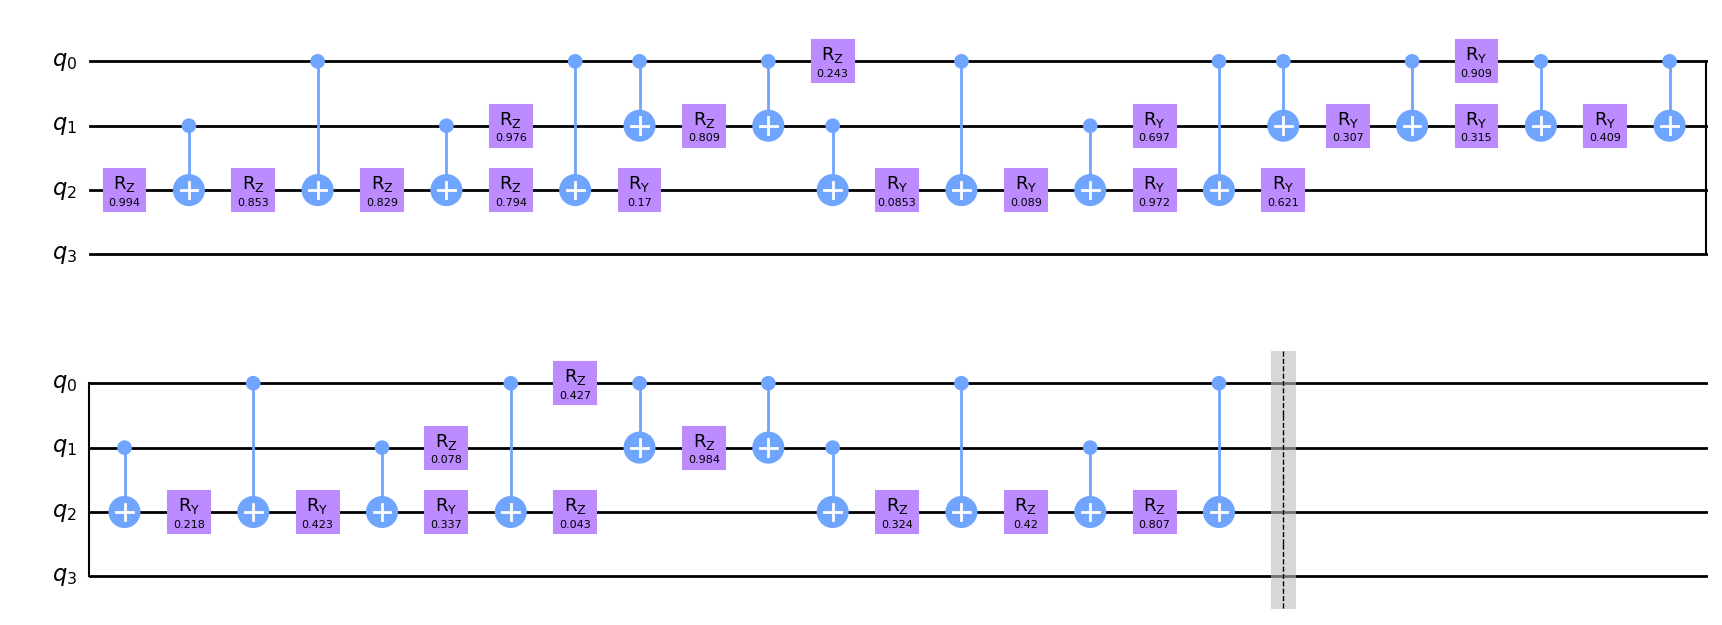

In [52]:
q_num = 4
param = np.array([np.random.rand() for _ in range(2**(q_num+2) - 5)])
circ = QuantumCircuit(q_num)
active_qubits = [i for i in range(q_num)]

pool = custom_conv_layer_fun(circ, param, active_qubits)
pool.draw(output='mpl')

In [6]:
from qiskit import quantum_info as qi

def embedding(wf):
    '''
    複素数のリストを引数にとり、それを係数にした波動関数を生成する
    '''
    q_state = qi.Statevector(wf)
    return q_state

In [9]:
wf = [0.5 for _ in range(4)]
state = embedding(wf)
print(type(state.data))

<class 'numpy.ndarray'>


In [17]:
import itertools
import numpy as np
all_binary_combs = list(map(list, itertools.product([0,1], repeat=3)))
new_list =np.array([elem for elem, val in enumerate(all_binary_combs) if val[3 // 2] == 1])
print(all_binary_combs)
print(new_list)

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
[2 3 6 7]


In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.converters import circuit_to_instruction
q = QuantumRegister(3, 'q')
c = ClassicalRegister(3, 'c')
circ = QuantumCircuit(q, c)
circ.h(q[0])
circ.cx(q[0], q[1])
circ.measure(q[0], c[0])
circ.rz(0.5, q[1]).c_if(c, 2)
a = circuit_to_instruction(circ)
print(a)

Instruction(name='circuit-87', num_qubits=3, num_clbits=3, params=[])
